# Часть 1

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import optuna
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans, DBSCAN

Считаем данные

In [2]:
df = pd.read_csv("https://www.dropbox.com/s/glmbcyopi24m2ni/final_project_data.csv?dl=1")

df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2011-11-23 14:36:35.0000003,2011-11-23 14:36:35 UTC,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5
1,2013-09-14 21:40:00.00000016,2013-09-14 21:40:00 UTC,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5
2,2012-04-30 18:13:19.0000002,2012-04-30 18:13:19 UTC,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5
3,2010-10-22 15:03:47.0000001,2010-10-22 15:03:47 UTC,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5
4,2011-02-18 18:08:16.0000002,2011-02-18 18:08:16 UTC,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1


## Исследование данных

In [4]:
df.info()
print('------')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615962 entries, 0 to 615961
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                615962 non-null  object 
 1   pickup_datetime    615962 non-null  object 
 2   pickup_longitude   615962 non-null  float64
 3   pickup_latitude    615961 non-null  float64
 4   dropoff_longitude  615959 non-null  float64
 5   dropoff_latitude   615959 non-null  float64
 6   passenger_count    615961 non-null  float64
 7   fare_amount        615961 non-null  float64
dtypes: float64(6), object(2)
memory usage: 37.6+ MB
------
key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      1
dropoff_longitude    3
dropoff_latitude     3
passenger_count      1
fare_amount          1
dtype: int64


In [3]:
# Удалим строки с пропусками

df.dropna(axis=0, inplace=True)

In [9]:
df.shape

(615959, 8)

In [4]:
# Удалим из данных колонку key, так как в ней дублируется информация из pickup_datetime

df.drop('key', axis=1, inplace=True)

In [ ]:
# Обработаем колонку `pickup_datetime`. Выделите из нее 4 новых столбца:

* `year` - год поездки
* `month` - месяц поездки
* `day` - день поездки
* `hour` - час поездки

Затем удалим столбец `pickup_datetime`.



In [5]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour


In [6]:
df.drop('pickup_datetime', axis=1, inplace=True)
df

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
0,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,14
1,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,21
2,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18
3,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15
4,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18
...,...,...,...,...,...,...,...,...,...,...
615956,-73.979049,40.736143,-73.980528,40.730353,1.0,5.5,2013,12,1,0
615957,-73.976600,40.745290,-73.980242,40.759672,2.0,10.5,2014,5,6,20
615958,-73.987750,40.745760,-73.953092,40.776787,1.0,10.9,2012,1,31,0
615959,-73.983165,40.728207,-74.002797,40.728670,1.0,7.5,2014,7,28,0


## Вопросы по данным

In [28]:
# В какие годы совершались поездки?

df['year'].value_counts().index.sort_values()

Index([2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype='int32', name='year')

In [32]:
# В какой час было совершено больше всего поездок?

df['hour'].value_counts().index[0]

19

In [54]:
# В какой сезон (зима, весна, лето, осень) было совершено наименьшее число поездок?

group_month = df.groupby('month')
group_month.size()

month
1     54827
2     52204
3     58039
4     56445
5     57758
6     55417
7     46723
8     44231
9     47044
10    49656
11    46673
12    46942
dtype: int64

<Axes: xlabel='pickup_latitude', ylabel='pickup_longitude'>

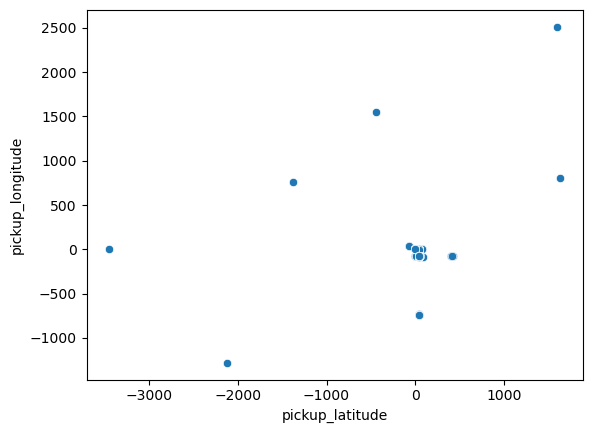

In [56]:
# Построим scatter plot в осях pickup_latitude и pickup_longitude

sns.scatterplot(data=df, x='pickup_latitude', y='pickup_longitude')

<Axes: >

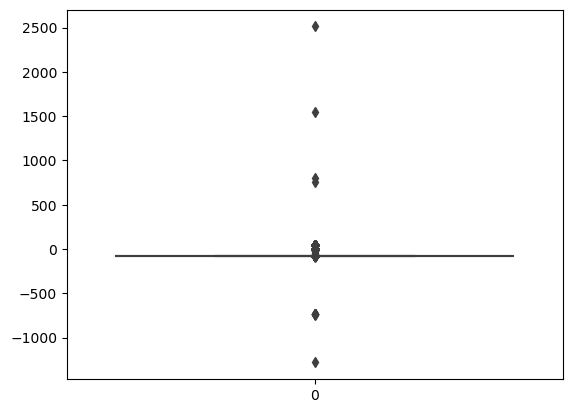

In [57]:
# Построим ящик с усами boxplot для pickup_longitude

sns.boxplot(df['pickup_longitude'])

In [58]:
# Чему равна медиана pickup_longitude

df['pickup_longitude'].median()

-73.981803

<Axes: xlabel='hour', ylabel='Count'>

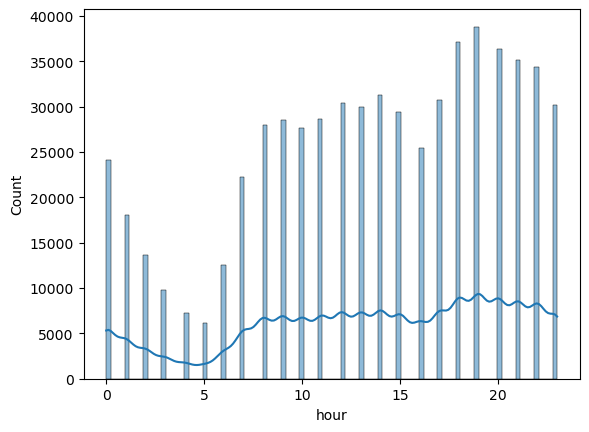

In [59]:
# Постройте гистограмму распределения признака hour

sns.histplot(df['hour'])

<Axes: xlabel='year', ylabel='month'>

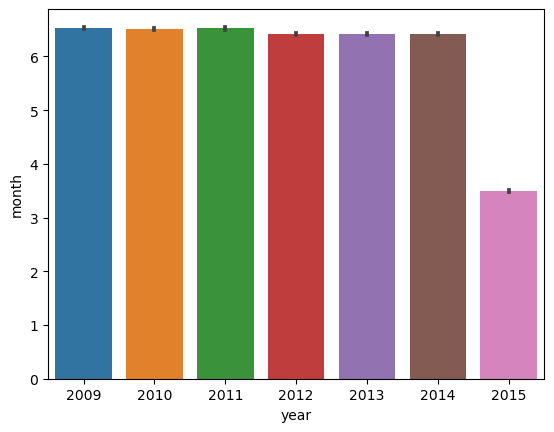

In [63]:
# Видим, что в 2015 году совершалось меньше поездок

sns.barplot(x=df['year'], y=df['month'])

<Axes: xlabel='year', ylabel='fare_amount'>

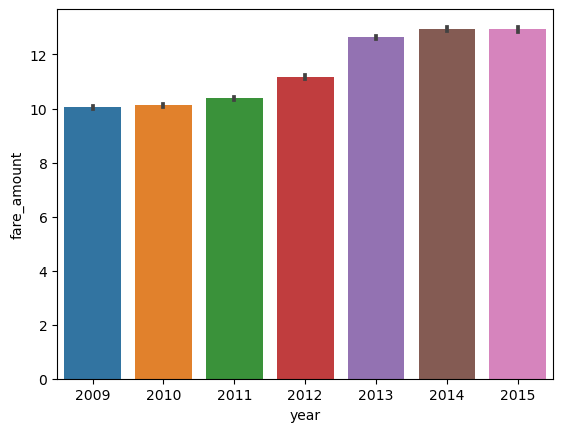

In [72]:
# Посмотрим на target от year

sns.barplot(x=df['year'], y=df['fare_amount'], )

<Axes: xlabel='fare_amount', ylabel='Count'>

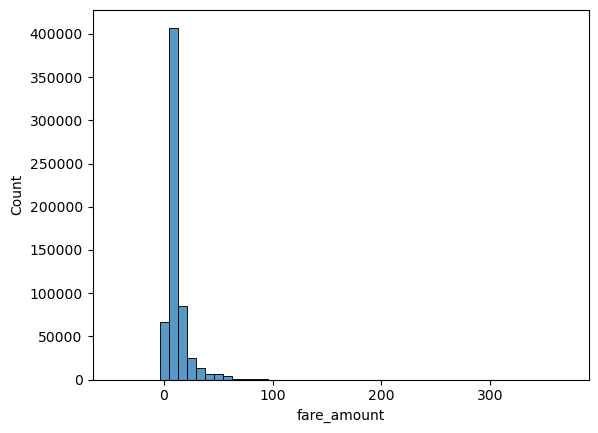

In [76]:
# Распределение цели - логнормальное

sns.histplot(df['fare_amount'], bins=50)

/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='fare_amount', ylabel='Count'>

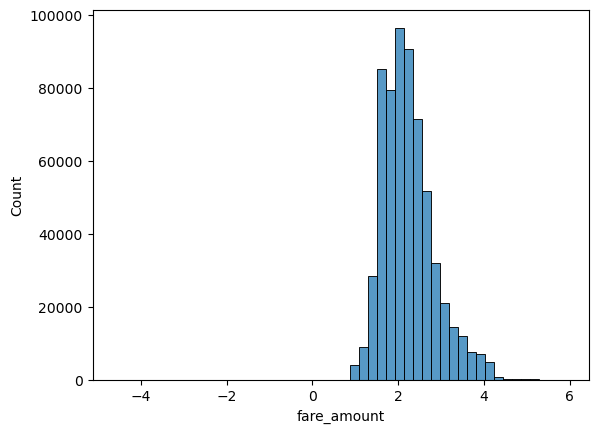

In [79]:
# Приведем в норм р-ние

sns.histplot(np.log(df['fare_amount']), bins=50)

## Построение baseline-модели

In [8]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

In [85]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)
Xtrain.shape

(461969, 9)

In [86]:
# Обучим решающее дерево глубины 3 на тренировочных данных


from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(Xtrain, ytrain)

preds_tree = tree.predict(Xtest)

r2_score(ytest, preds_tree)

0.4998349394485503

In [88]:
# гистограмма важности признаков.

feach_importance_tree = pd.DataFrame(tree.feature_importances_, index=Xtrain.columns).sort_values(by=0, 
                                                                                                  ascending=False)
feach_importance_tree

,0
dropoff_longitude,0.637263
pickup_longitude,0.311747
pickup_latitude,0.050990
dropoff_latitude,0.000000
passenger_count,0.000000
year,0.000000
month,0.000000
day,0.000000
hour,0.000000


([<matplotlib.axis.YTick at 0x2b3ffe090>,
 [Text(0, 0, 'hour'),
  Text(0, 1, 'day'),
  Text(0, 2, 'month'),
  Text(0, 3, 'year'),
  Text(0, 4, 'passenger_count'),
  Text(0, 5, 'dropoff_latitude'),
  Text(0, 6, 'pickup_latitude'),
  Text(0, 7, 'pickup_longitude'),
  Text(0, 8, 'dropoff_longitude')])

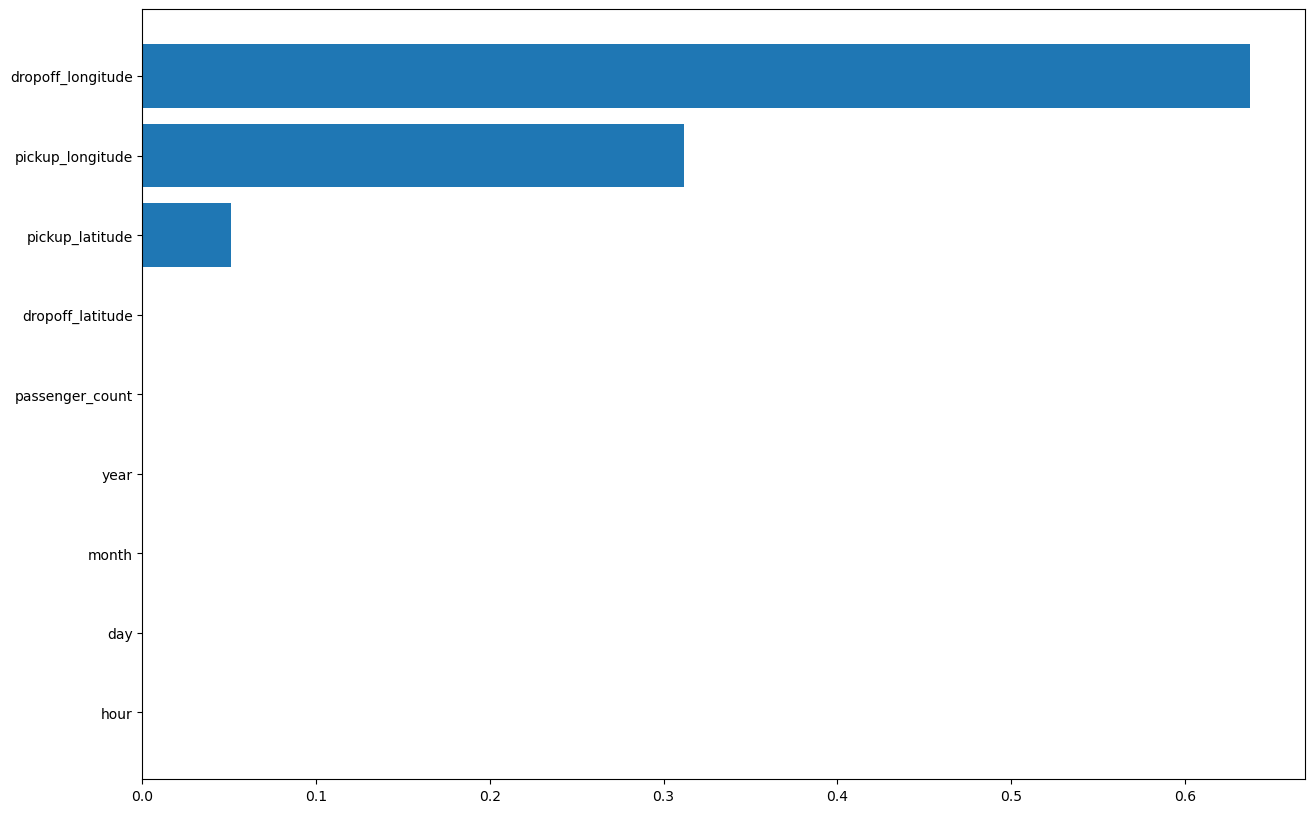

In [94]:
plt.figure(figsize=(15, 10))

plt.barh(range(len(feach_importance_tree.values)), feach_importance_tree.values.flatten()[::-1], align='center')
plt.yticks(range(len(feach_importance_tree.index)), feach_importance_tree.index[::-1])

## Улучшение модели

In [9]:
# Заменим все значения  𝑦, меньшие 0, на 0.
# Сделаем преобразование целевой переменной по правилу  𝑦𝑛𝑒𝑤=𝑛𝑝.𝑙𝑜𝑔1𝑝(𝑦)

y = y.apply(lambda x: 0 if x < 0 else x)
ynew = np.log1p(y)


<Axes: xlabel='fare_amount', ylabel='Count'>

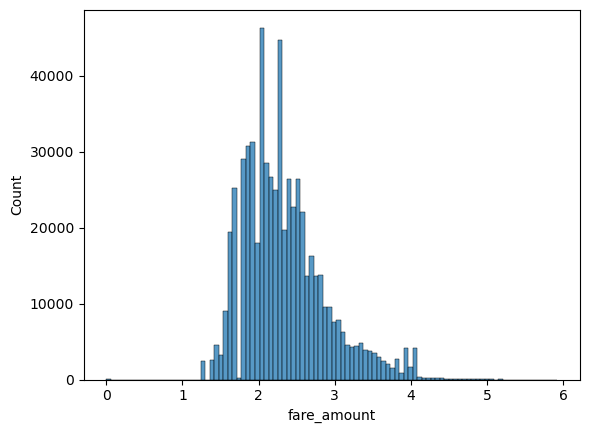

In [98]:
sns.histplot(ynew, bins=100)

In [99]:
Xtrain, Xtest, ytrain_new, ytest_new = train_test_split(X, ynew, test_size=0.25, random_state=42)
Xtrain.shape

(461969, 9)

In [102]:
tree_new = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_new.fit(Xtrain, ytrain_new)

preds_tree_new = tree_new.predict(Xtest)

r2_score(np.expm1(ytest_new), np.expm1(preds_tree_new))

0.44346012656908607

In [104]:
# Подберите по кросс-валидации на тренировочных данных глубину дерева в диапазоне от 3 до 10 включительно с шагом 1 (random_state=42).
# cv=3, scoring=r2

params_tree = {
    'max_depth': np.arange(3, 11, 1)
}

gs_tree = GridSearchCV(DecisionTreeRegressor(random_state=42), params_tree, cv=3, scoring='r2')

gs_tree.fit(Xtrain, ytrain_new)

gs_tree.best_score_, gs_tree.best_estimator_

(0.5616182564633098, DecisionTreeRegressor(max_depth=10, random_state=42))

In [105]:
tree_best = gs_tree.best_estimator_

tree_best.fit(Xtrain, ytrain_new)

preds_tree_best = tree_best.predict(Xtest)
r2_score(np.expm1(ytest_new), np.expm1(preds_tree_best))

0.6884366399590435

## Усложнение пайплайна

In [106]:
# Создадим pipeline, в котором сначала извлечем полиномиальные признаки степени 2 из данных,
# а затем обучим решающее дерево глубины 3 с random_state=42.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

p1 = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('model', DecisionTreeRegressor(max_depth=3, random_state=42))
])

In [107]:
p1.fit(Xtrain, ytrain_new)
preds_p1 = p1.predict(Xtest)
r2_score(np.expm1(ytest_new), np.expm1(preds_p1))

0.4173231422216578

In [120]:
# Определяем Pipeline
p2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Определяем сетку параметров для GridSearchCV
params_grid = {
    'poly__degree': [2],  # Параметр для PolynomialFeatures
    'model__max_depth': np.arange(3, 11, 1)  # Параметр для DecisionTreeRegressor
}

# Создаем объект GridSearchCV
gs_tree_p2 = GridSearchCV(p2, params_grid, cv=3, scoring='r2')

# Предполагается, что Xtrain и ytrain_new определены
gs_tree_p2.fit(Xtrain, ytrain_new)

# Выводим лучшую оценку и лучший оценщик
print(gs_tree_p2.best_score_)
print(gs_tree_p2.best_estimator_)

0.6660345220391574
Pipeline(steps=[('poly', PolynomialFeatures()),
                ('model',
                 DecisionTreeRegressor(max_depth=10, random_state=42))])


In [122]:
model_p2 = gs_tree_p2.best_estimator_
model_p2.fit(Xtrain, ytrain_new)
preds_p2 = model_p2.predict(Xtest)
r2_score(np.expm1(ytest_new), np.expm1(preds_p2))

0.7141815704902021

## Feature selection

In [123]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge


In [125]:
# Добавим в предыдущий пайплайн: после добавления полиномиальных признаков - StandardScaler
# затем - снижение размерности при помощи метода SelectFromModel с моделью Ridge с гиперпараметрами по умолчанию.

p3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('selectror', SelectFromModel(Ridge())),
    ('model', DecisionTreeRegressor(random_state=42))
])


In [126]:
p3.fit(Xtrain, ytrain_new)
preds_p3 = p3.predict(Xtest)
r2_score(np.expm1(ytest_new), np.expm1(preds_p3))


0.6086933329018949

In [138]:
params_p3 = {
    'poly__degree': [2],
    'model__max_depth': np.arange(3, 11, 1)
}

gs_tree_p3 = GridSearchCV(p3, params_p3, cv=3, scoring='r2')

gs_tree_p3.fit(Xtrain, ytrain_new)

gs_tree_p3.best_score_, gs_tree_p3.best_estimator_

(0.6046864701480109,
 Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                 ('selectror', SelectFromModel(estimator=Ridge())),
                 ('model',
                  DecisionTreeRegressor(max_depth=10, random_state=42))]))

In [139]:
model_p3 = gs_tree_p3.best_estimator_
model_p3.fit(Xtrain, ytrain_new)
preds_p3 = model_p3.predict(Xtest)
r2_score(np.expm1(ytest_new), np.expm1(preds_p3))

0.6698534940345506

### Quiz

Удалось ли при помощи пайплайна с отбором признаков улучшить результат предыдущей лучшей модели?

In [ ]:
# Нет, не удалось (

## Кодирование категориальных признаков

Признаки month, day, hour - категориальные


Попробуем подход: группировка значений признака + дальнейшая OneHot-кодировка.

колонки winter, spring, summer, autumn - в каждую из которых пишем 1, если месяц относится к сезону, и 0 иначе.

колонки start_month, middle_month, end_month - в каждую колонку пишем 1, если день относится к началу месяца (1-10 число), середине месяца (11-20 число), концу месяца (от 21 числа), и 0 иначе.

колонки night, morning, day, evening по аналогии. Если час - от 23 до 5, то это night, от 6 до 11 - morning, от 12 до 16 - day, от 17 до 22 - evening.

После создания новых колонок удалим колонки month, day, hour.



In [7]:
df['winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
df['spring'] = df['month'].apply(lambda x: 1 if x in [3,4,5] else 0)
df['summer'] = df['month'].apply(lambda x: 1 if x in [6,7,8] else 0)
df['autumn'] = df['month'].apply(lambda x: 1 if x in [9,10,11] else 0)


In [8]:
df['start_month'] = df['day'].apply(lambda x: 1 if x in np.arange(1, 11) else 0)
df['middle_month'] = df['day'].apply(lambda x: 1 if x in np.arange(11, 21) else 0)
df['end_month'] = df['day'].apply(lambda x: 1 if x > 21 else 0)


In [9]:
df['night'] = df['hour'].apply(lambda x: 1 if x in [23, 0, 1, 2, 3, 4, 5] else 0)
df['morning'] = df['hour'].apply(lambda x: 1 if x in np.arange(6, 12) else 0)
df['day'] = df['hour'].apply(lambda x: 1 if x in np.arange(12, 17) else 0)
df['evening'] = df['hour'].apply(lambda x: 1 if x in np.arange(17, 23) else 0)

In [10]:
df.drop(['month', 'day', 'hour'], axis=1, inplace=True)

In [291]:
df.shape

(615959, 17)

In [11]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

In [12]:
y = y.apply(lambda x: 0 if x < 0 else x)
ynew = np.log1p(y)

Xtrain, Xtest, ytrain_new, ytest_new = train_test_split(X, ynew, test_size=0.25, random_state=42)
Xtrain.shape

(461969, 16)

In [192]:
params_new_feat_tree = {
    'max_depth': np.arange(3, 11, 1)
}

gs_tree_new_ft = GridSearchCV(DecisionTreeRegressor(random_state=42), params_new_feat_tree, cv=3, scoring='r2')

gs_tree_new_ft.fit(Xtrain, ytrain_new)

gs_tree_new_ft.best_score_, gs_tree_new_ft.best_estimator_


(0.5625604250448296, DecisionTreeRegressor(max_depth=10, random_state=42))

In [193]:
model_3_new = gs_tree_new_ft.best_estimator_
model_3_new.fit(Xtrain, ytrain_new)
preds_3_new = model_3_new.predict(Xtest)
r2_score(np.expm1(ytest_new), np.expm1(preds_3_new))

0.6818619932356063

In [195]:
feature_importanc = pd.DataFrame(model_3_new.feature_importances_,
                                 index=Xtrain.columns).sort_values(by=0, ascending=False)
feature_importanc

,0
dropoff_longitude,0.417100
pickup_longitude,0.237037
dropoff_latitude,0.188100
pickup_latitude,0.128473
year,0.027483
passenger_count,0.000606
autumn,0.000260
night,0.000211
morning,0.000196
middle_month,0.000155


### Quiz

Какой из признаков, связанных с датой поездки, самый важный для модели?

In [ ]:
# --> year

## Кластеризация и визуализация

In [ ]:
# Оставим только те строчки в таблице df (после удаления пропусков), для которых выполнены оба условия:

# dropoff_latitude  ∈(39;41)
 
# dropoff_longitude  ∈(−75;−72)

In [13]:
df = df[(df['dropoff_latitude'] > 39) & (df['dropoff_latitude'] < 41)]
df = df[(df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -72)]

<Axes: xlabel='dropoff_longitude', ylabel='fare_amount'>

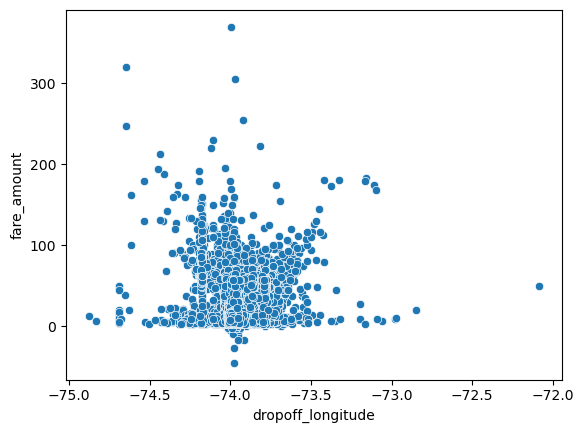

In [199]:
sns.scatterplot(x=df['dropoff_longitude'], y=df['fare_amount'])

In [14]:
df_long_lat = df[['dropoff_latitude', 'dropoff_longitude']]
df_long_lat

,dropoff_latitude,dropoff_longitude
0,40.783345,-73.959087
1,40.760542,-73.929097
2,40.727725,-74.007197
3,40.755807,-73.985609
4,40.722350,-73.983280
...,...,...
615956,40.730353,-73.980528
615957,40.759672,-73.980242
615958,40.776787,-73.953092
615959,40.728670,-74.002797


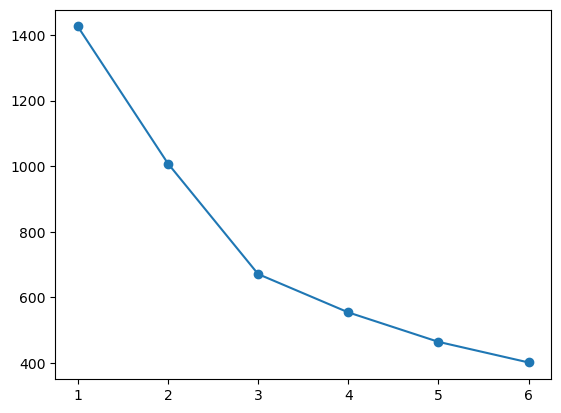

In [206]:
# Используем метод локтя для понимания оптимального количества кластеров

from sklearn.cluster import KMeans

distortions = []

for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_long_lat)
    
    distortions.append(kmeans.inertia_)

plt.plot(np.arange(1, 7), distortions, marker = 'o')

/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


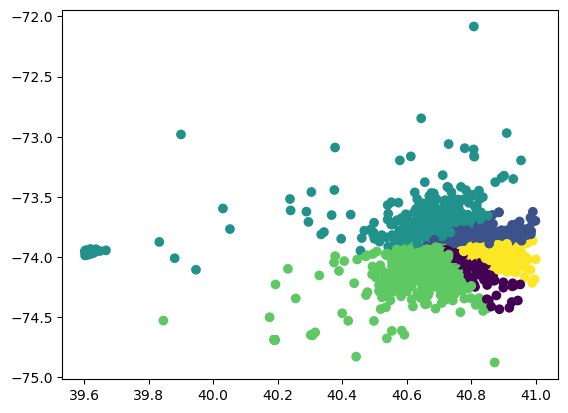

In [15]:
# Возьмем 5 кластеров
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(df_long_lat)

plt.scatter(df_long_lat.loc[:, 'dropoff_latitude'], df_long_lat.loc[:, 'dropoff_longitude'], c=kmeans.labels_)

In [16]:
# Создадим новый признак clusters

df['clusters'] = kmeans.labels_

In [22]:
df['clusters'].value_counts()

clusters
0    295518
4    143058
3    137405
1     20731
2      7017
Name: count, dtype: int64

In [23]:
# Среднее значение стоимости поездки по кластерам

mean_clusters = df.groupby('clusters')['fare_amount'].mean()
mean_clusters

clusters
0     9.576575
1    23.940778
2    40.123088
3    12.652495
4    10.333062
Name: fare_amount, dtype: float64

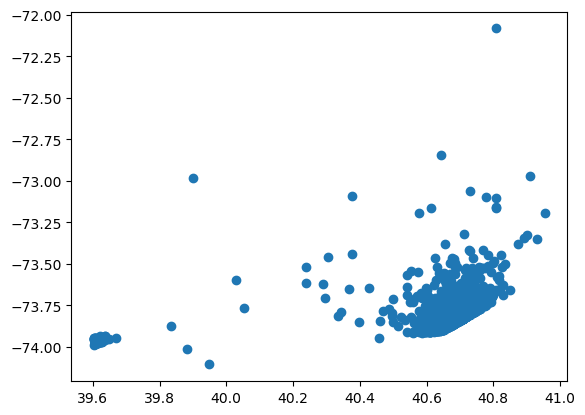

In [23]:
# нарисуем кластер с наибольшей средней стоимостью поездки

df_max_avg_fares = df_long_lat[df['clusters'] == 2]

plt.scatter(df_max_avg_fares['dropoff_latitude'], df_max_avg_fares['dropoff_longitude'])

Кластеризуем точки этого кластера при помощи DBSCAN с гиперпараметрами eps=0.15, min_samples=10.

Вычислим координаты центра (среднее арифметрическое) меньшего кластера.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


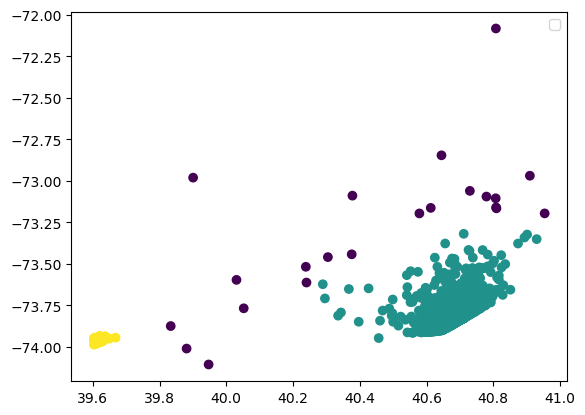

In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.15, min_samples=10)

dbscan.fit(df_max_avg_fares)

plt.scatter(df_max_avg_fares.iloc[:, 0], df_max_avg_fares.iloc[:, 1], c=dbscan.labels_)
plt.legend()

In [252]:
df_max_avg_fares['dropoff_latitude'][df_max_avg_fares['clusters'] == 1].mean()

39.6163248012393

FeachEngeneering

In [17]:
# Новый признак - расстояние поездки - по формуле гаверсинуса

import math

def haversine(lat1, lon1, lat2, lon2):
    """
    Вычисляет расстояние между двумя точками на поверхности Земли по координатам
    в градусах с использованием формулы гаверсинуса.
    """
    # Радиус Земли в километрах
    R = 6371.0

    # Преобразование градусов в радианы
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Разница между широтой и долготой
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Вычисление расстояния по формуле гаверсинуса
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c

    return distance


# Пример координат двух точек (Широта и долгота в градусах)
lat_pickup = df['pickup_latitude'].values
lon_pickup = df['pickup_longitude'].values
lat_dropoff = df['dropoff_latitude'].values
lon_dropoff = df['dropoff_longitude'].values

# Вычисление расстояния между этими точками
distance_km = haversine(lat_pickup, lon_pickup, lat_dropoff, lon_dropoff)
distance_km

array([3.37922722e-03, 1.18857273e+00, 1.66827145e+00, ...,
       4.51922506e+00, 1.65508534e+00, 4.37798320e+00])

In [18]:
# Добавим новый признак в df

df['distance'] = distance_km
df

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,winter,spring,summer,autumn,start_month,middle_month,end_month,night,morning,evening,clusters,distance
0,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,0,0,0,1,0,0,1,0,0,0,4,0.003379
1,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,0,0,0,1,0,1,0,0,0,1,4,1.188573
2,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,0,1,0,0,0,0,1,0,0,1,3,1.668271
3,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,0,0,0,1,0,0,1,0,0,0,0,1.543928
4,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,1,0,0,0,0,1,0,0,0,1,3,2.169588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615956,-73.979049,40.736143,-73.980528,40.730353,1.0,5.5,2013,1,0,0,0,1,0,0,1,0,0,3,0.655768
615957,-73.976600,40.745290,-73.980242,40.759672,2.0,10.5,2014,0,1,0,0,1,0,0,0,0,1,0,1.628365
615958,-73.987750,40.745760,-73.953092,40.776787,1.0,10.9,2012,1,0,0,0,0,0,1,1,0,0,4,4.519225
615959,-73.983165,40.728207,-74.002797,40.728670,1.0,7.5,2014,0,0,1,0,0,0,1,1,0,0,3,1.655085


<Axes: >

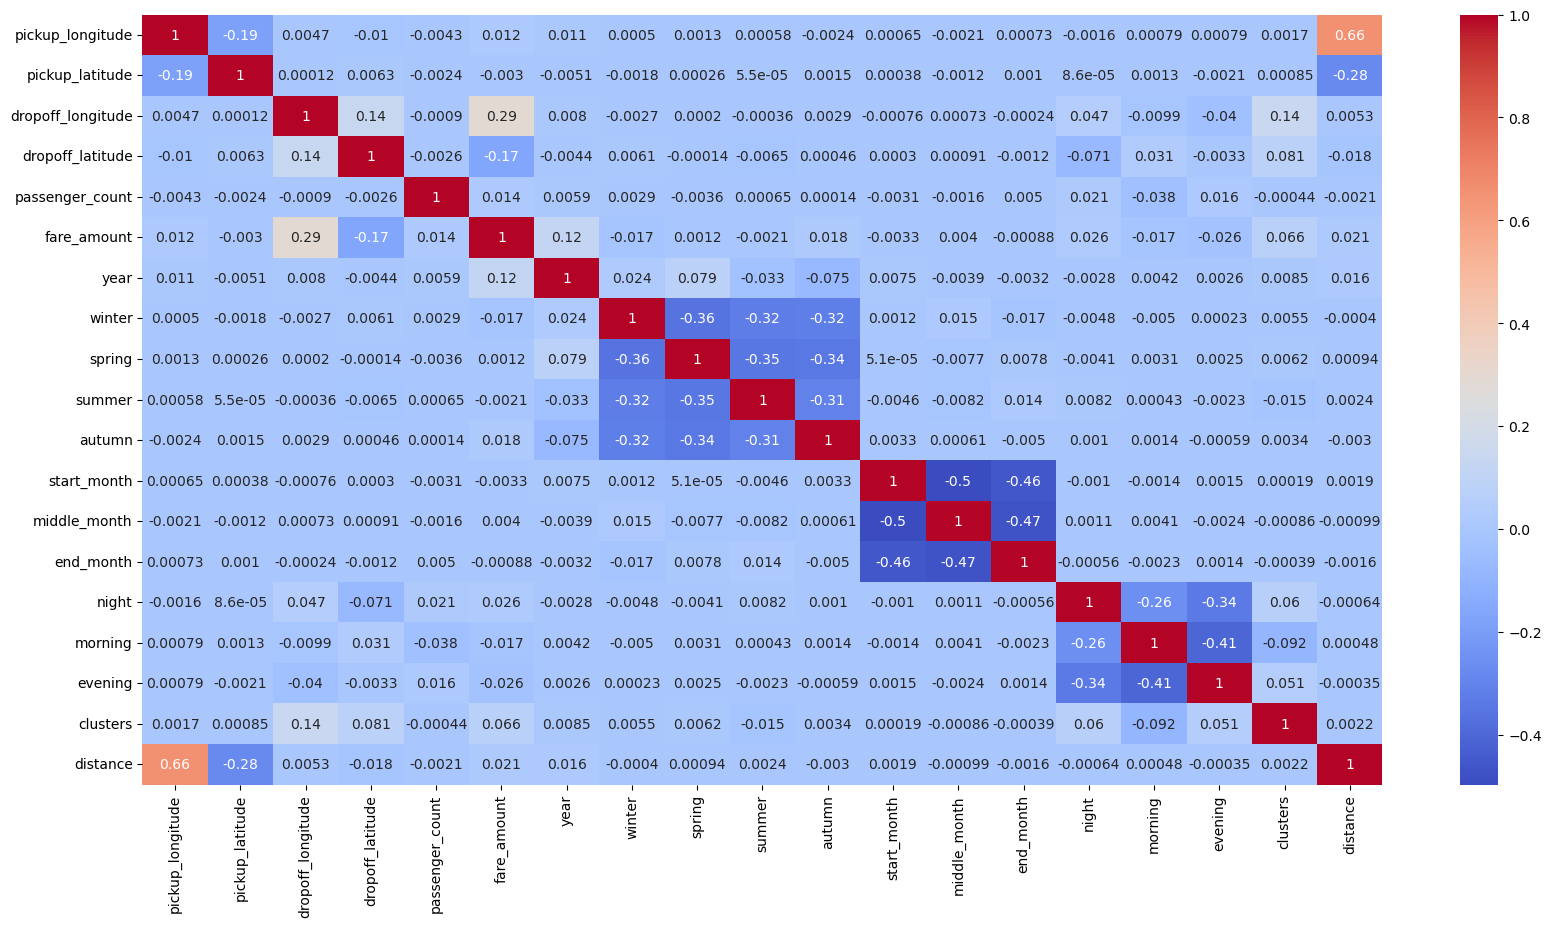

In [24]:
# Построим матрицу корреляции

correl = df.corr()

plt.figure(figsize=(20, 10))

sns.heatmap(correl, cmap='coolwarm', annot=True)



In [27]:
# У distance есть выбросы, как поездки в 8000 км )
# Отфильтруем и

dist_low = df[df['distance']< 140]

<Axes: xlabel='distance', ylabel='fare_amount'>

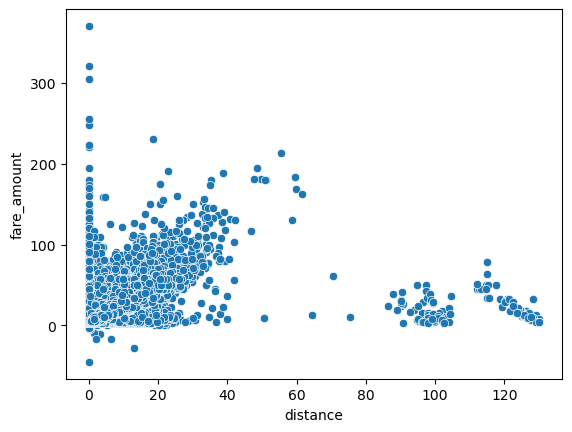

In [28]:
# Попробуем посмотреть как distance влияет на fare_amount

sns.scatterplot(x=dist_low['distance'], y=dist_low['fare_amount'])

In [349]:
# Тут оберзались выбросовые поездки и остались более менее логичные
# Но есть поездки под 0 км с огромной платой - посмотрим на них
# Плюс отрезать надо плату < 0 долларов

In [355]:
df[df['fare_amount'] == 0]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,winter,spring,summer,autumn,start_month,middle_month,end_month,night,morning,evening,clusters,distance
21427,-74.027115,40.752872,-74.027122,40.752895,0.0,0.0,2015,1,0,0,0,0,1,0,1,0,0,0,0.002625
82135,-73.937439,40.758160,-73.937439,40.758160,1.0,0.0,2015,0,1,0,0,0,0,0,1,0,0,4,0.000000
100317,-73.982119,40.761697,-73.984814,40.747882,1.0,0.0,2010,1,0,0,0,0,0,0,0,0,1,0,1.552840
129364,-73.791212,40.642660,-73.979791,40.740578,1.0,0.0,2010,0,1,0,0,0,0,1,0,0,0,0,19.270105
245008,-73.975174,40.750538,-73.977112,40.751740,1.0,0.0,2015,0,1,0,0,0,0,1,0,0,1,0,0.210949
247566,-73.995435,40.717126,-73.995158,40.717684,1.0,0.0,2010,1,0,0,0,0,0,0,0,0,1,3,0.066293
286768,-73.900775,40.758302,-73.900775,40.758302,1.0,0.0,2013,0,0,1,0,0,0,1,0,1,0,1,0.000000
315949,-73.685662,40.769571,-73.685611,40.769482,1.0,0.0,2010,0,1,0,0,0,0,1,0,0,0,2,0.010788
368408,-73.983101,40.765324,-73.994751,40.761780,1.0,0.0,2015,0,0,1,0,1,0,0,1,0,0,0,1.057347
426473,-73.989840,40.758272,-73.989697,40.758500,1.0,0.0,2013,0,0,1,0,0,0,0,0,1,0,0,0.028068


<Axes: xlabel='distance', ylabel='fare_amount'>

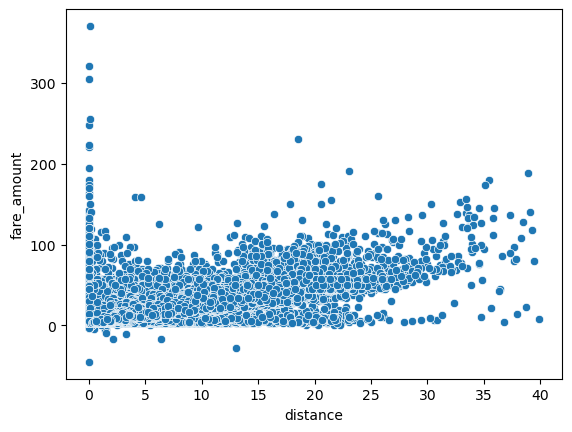

In [32]:
low_fares = df[df['distance'] < 40]

sns.scatterplot(x=low_fares['distance'], y=low_fares['fare_amount'])

<Axes: xlabel='distance', ylabel='fare_amount'>

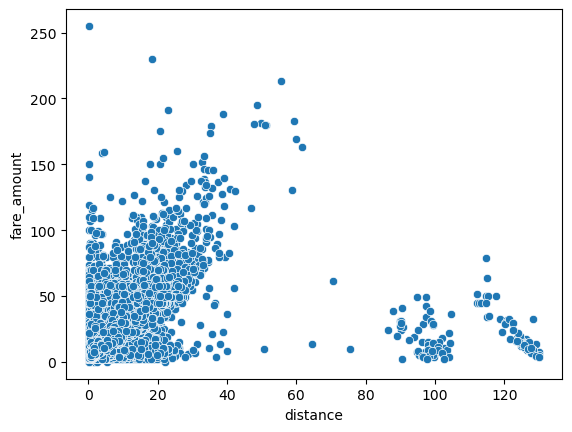

In [19]:
# Удалим из датасета 1) где расстояние > 140 км, 2) где плата отрицательна и где плата = 0

df_new = df[(df['distance'] < 140) & (df['distance'] > 1e-1) & (df['fare_amount'] > 0.0)]

sns.scatterplot(x=df_new['distance'], y=df_new['fare_amount'])


<Axes: >

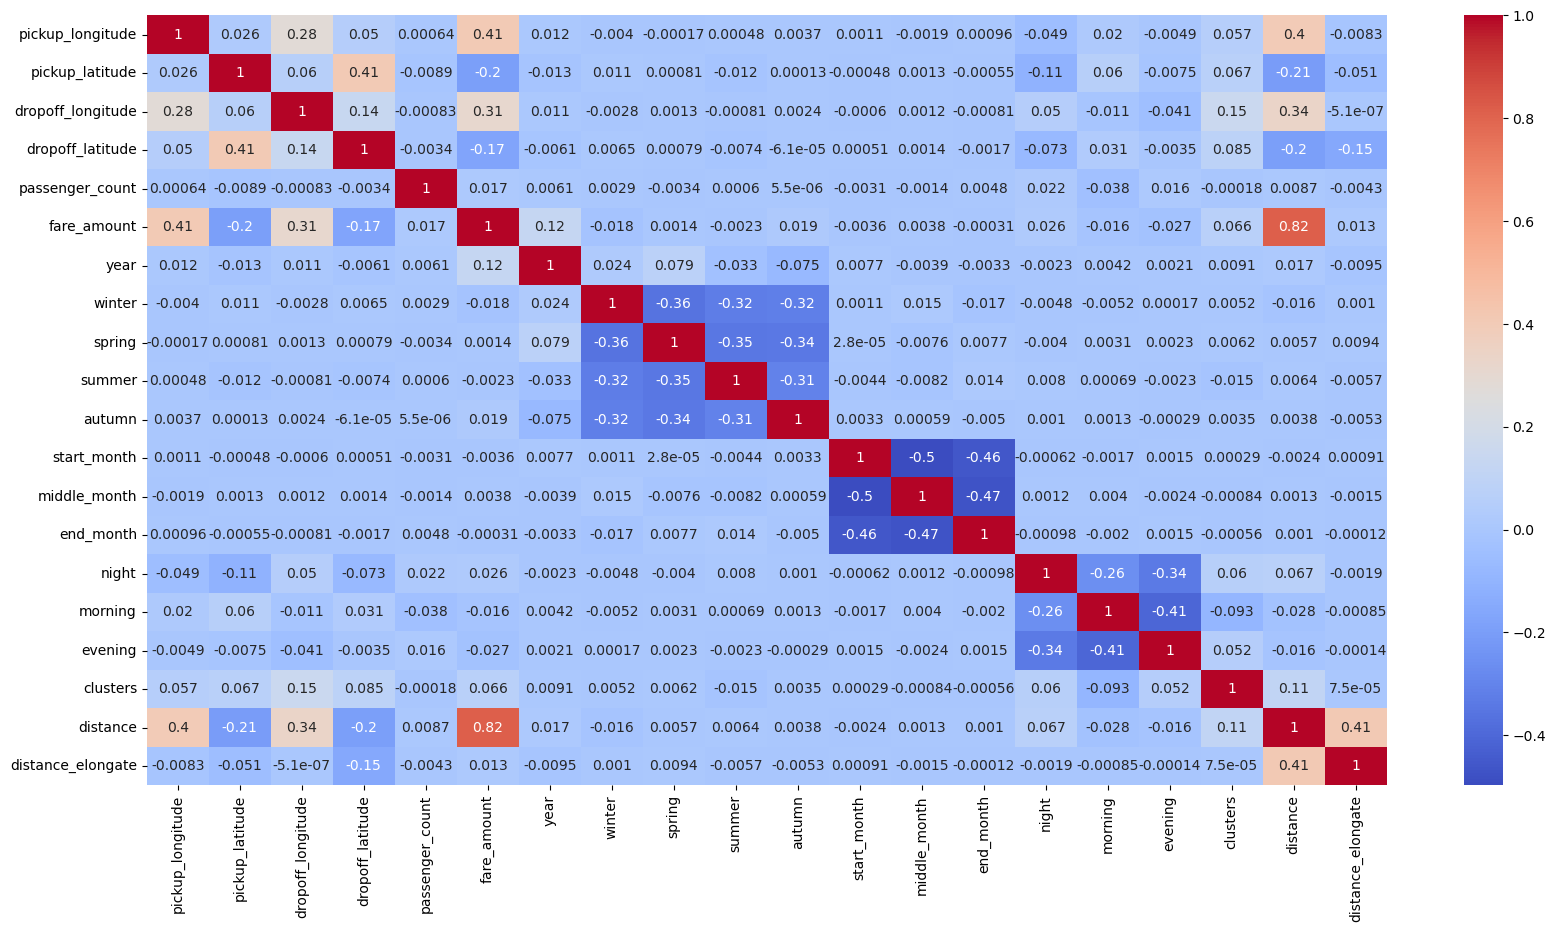

In [33]:
# Построим матрицу корреляции еще раз - очень сильная зависимость с фичей distance

correl = df_new.corr()

plt.figure(figsize=(20, 10))

sns.heatmap(correl, cmap='coolwarm', annot=True)

In [36]:
X = df_new.drop('fare_amount', axis=1)
y = df_new['fare_amount']

In [43]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

([<matplotlib.axis.XTick at 0x2d2a39b10>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18')])

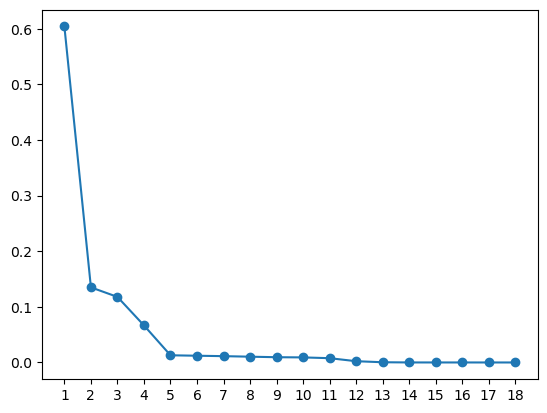

In [39]:
# Попробуем снижение размерности - посмотрим сколько компонент содержат наибольшее кол-во информации

from sklearn.decomposition import PCA

pca = PCA(n_components=X.shape[1])
pca.fit_transform(X)

var = pca.explained_variance_ratio_

n_comp = np.arange(X.shape[1]) + 1

plt.plot(n_comp, var, marker = 'o')

plt.xticks(np.arange(1, 19))


In [40]:
# Сделаем РСА для 4 компонент, посмотрим какие признаки вносят основной вклад

pca = PCA(n_components=4)

pca.fit_transform(X)

components = pca.components_

components_df = pd.DataFrame(components, columns=X.columns)

# Выбираем 10 признаков с наибольшими весами

for i, row in components_df.iterrows():
    print(f"Component {i+1}:")
    top_features = row.abs().nlargest(10)  
    print(top_features)
    print()



Component 1:
distance             0.998077
clusters             0.060255
year                 0.010462
night                0.006740
pickup_longitude     0.003710
morning              0.003393
passenger_count      0.003242
dropoff_longitude    0.002953
evening              0.001775
winter               0.001737
Name: 0, dtype: float64

Component 2:
year               0.998206
clusters           0.049604
spring             0.020642
autumn             0.018282
distance           0.013471
summer             0.008427
passenger_count    0.008081
winter             0.006067
start_month        0.002132
evening            0.001397
Name: 1, dtype: float64

Component 3:
clusters             0.996427
distance             0.059748
year                 0.050337
morning              0.024048
evening              0.016508
night                0.011870
summer               0.003825
passenger_count      0.002295
dropoff_latitude     0.002096
dropoff_longitude    0.002006
Name: 2, dtype: float64

Compon

In [42]:
# Попробуем отобрать признаки с помощью RFE
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import optuna
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [62]:
# Отберем признаки по RFE и SFM

estimators = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression()
    }

params = {
    'n_features_to_select': np.arange(10, X.shape[1]+1)
}

gs_rfe = GridSearchCV(RFE(estimator=estimators['RandomForest']), params, cv=3, scoring='r2', n_jobs=-1)
gs_rfe.fit(Xtrain.iloc[:10000, :], ytrain.iloc[:10000])

gs_rfe.best_score_, gs_rfe.best_estimator_

(0.8537725512762245,
 RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=16))

In [69]:
rfe = gs_rfe.best_estimator_
indices = rfe.get_support(indices=True)
ranks = rfe.ranking_
names = Xtrain.columns.to_list()

ranks_names = list(zip(ranks, names))
ranks_names

[(1, 'pickup_longitude'),
 (1, 'pickup_latitude'),
 (1, 'dropoff_longitude'),
 (1, 'dropoff_latitude'),
 (1, 'passenger_count'),
 (1, 'year'),
 (1, 'winter'),
 (3, 'spring'),
 (1, 'summer'),
 (1, 'autumn'),
 (2, 'start_month'),
 (1, 'middle_month'),
 (1, 'end_month'),
 (1, 'night'),
 (1, 'morning'),
 (1, 'evening'),
 (1, 'clusters'),
 (1, 'distance')]

In [72]:
# SelectFromModel

sfm = SelectFromModel(estimator=RandomForestRegressor(random_state=42))
X_sfm = sfm.fit(Xtrain.iloc[:10000, :], ytrain.values[:10000])



In [75]:
# Выведем Feature_importances_

scores = X_sfm.estimator_.feature_importances_

names = X.columns.to_list()

f_i = pd.DataFrame(scores, index=names).sort_values(by=0, ascending=False)
f_i

,0
distance,0.851031
dropoff_longitude,0.041480
pickup_longitude,0.024405
dropoff_latitude,0.021353
year,0.021291
pickup_latitude,0.016082
clusters,0.006768
passenger_count,0.003383
night,0.002103
autumn,0.002015


In [77]:
# По оберточным методам отберем 16 признаков для обучения модели
must_features = f_i.index.to_list()[:-2]


['distance',
 'dropoff_longitude',
 'pickup_longitude',
 'dropoff_latitude',
 'year',
 'pickup_latitude',
 'clusters',
 'passenger_count',
 'night',
 'autumn',
 'middle_month',
 'morning',
 'evening',
 'summer',
 'end_month',
 'winter']

In [92]:
# Оставим только наиболее важные признаки

df_for_training = df_new.loc[:, must_features]
df_for_training

,distance,dropoff_longitude,pickup_longitude,dropoff_latitude,year,pickup_latitude,clusters,passenger_count,night,autumn,middle_month,morning,evening,summer,end_month,winter
1,1.188573,-73.929097,-73.931612,40.760542,2013,40.771060,4,1.0,0,1,1,0,1,0,0,0
2,1.668271,-74.007197,-73.997929,40.727725,2012,40.740983,3,2.0,0,0,0,0,1,0,1,0
3,1.543928,-73.985609,-73.980608,40.755807,2010,40.742449,0,1.0,0,1,0,0,0,0,1,0
4,2.169588,-73.983280,-74.008884,40.722350,2011,40.720314,3,1.0,0,0,1,0,1,0,0,1
5,1.892831,-73.960058,-73.973728,40.805453,2010,40.791937,4,5.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615956,0.655768,-73.980528,-73.979049,40.730353,2013,40.736143,3,1.0,1,0,0,0,0,0,0,1
615957,1.628365,-73.980242,-73.976600,40.759672,2014,40.745290,0,2.0,0,0,0,0,1,0,0,0
615958,4.519225,-73.953092,-73.987750,40.776787,2012,40.745760,4,1.0,1,0,0,0,0,0,1,1
615959,1.655085,-74.002797,-73.983165,40.728670,2014,40.728207,3,1.0,1,0,0,0,0,1,1,0


Подберем гиперпараметры и обучим модель LGBMRegressor

In [93]:
X = df_for_training

In [94]:
y = y.apply(lambda x: 0 if x < 0 else x)
ynew = np.log1p(y)


In [97]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, ynew, test_size=0.25, random_state=42)

In [101]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 20, step = 2),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1)
        #'min_child_samples': trial.suggest_int('min_child_samples', 3, 20)
        
    }
    
    model = LGBMRegressor(**params)
    model.fit(Xtrain, ytrain)
    preds = model.predict(Xtest)
    
    score = r2_score(np.expm1(preds), np.expm1(ytest))
    
    return score

In [102]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
study.best_params

[I 2024-04-28 00:21:50,603] A new study created in memory with name: no-name-bfc03186-24f5-4e71-8811-10bacad64c9d
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:22:01,591] Trial 0 finished with value: 0.8277895373447908 and parameters: {'n_estimators': 508, 'max_depth': 6, 'learning_rate': 0.012631117587323722, 'reg_alpha': 0.041190723872937506, 'reg_lambda': 0.8998621825901536}. Best is trial 0 with value: 0.8277895373447908.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/fo

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583


[I 2024-04-28 00:22:03,503] Trial 1 finished with value: -78771.29629119004 and parameters: {'n_estimators': 184, 'max_depth': 2, 'learning_rate': 3.93271568057575e-05, 'reg_alpha': 0.9513830157590344, 'reg_lambda': 0.00040566273715408435}. Best is trial 0 with value: 0.8277895373447908.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:22:24,160] Trial 2 finished with value: 0.8158009567727336 and parameters: {'n_estimators': 824, 'max_depth': 10, 'learning_rate': 0.0061351227981662855, 'reg_alpha': 0.9093400678871342, 'reg_lambda': 0.8339351421389719}. Best is trial 0 with value: 0.8277895373447908.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/fo

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:22:35,579] Trial 3 finished with value: 0.857862198702175 and parameters: {'n_estimators': 720, 'max_depth': 10, 'learning_rate': 0.053795485124047124, 'reg_alpha': 0.2616782515707189, 'reg_lambda': 0.059642323524959594}. Best is trial 3 with value: 0.857862198702175.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/fol

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:22:38,962] Trial 4 finished with value: -272.9050820396461 and parameters: {'n_estimators': 137, 'max_depth': 10, 'learning_rate': 0.000827279385040636, 'reg_alpha': 0.025484513172518534, 'reg_lambda': 0.12601519665632954}. Best is trial 3 with value: 0.857862198702175.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:22:47,070] Trial 5 finished with value: 0.8457959793422843 and parameters: {'n_estimators': 378, 'max_depth': 10, 'learning_rate': 0.03723937210205871, 'reg_alpha': 0.017211217487182986, 'reg_lambda': 0.0011098575681309946}. Best is trial 3 with value: 0.857862198702175.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583


[I 2024-04-28 00:22:47,781] Trial 6 finished with value: -109241.58717486242 and parameters: {'n_estimators': 20, 'max_depth': 16, 'learning_rate': 0.00029057156118137583, 'reg_alpha': 0.007788559777304298, 'reg_lambda': 0.8910715011491932}. Best is trial 3 with value: 0.857862198702175.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_l

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:23:04,339] Trial 7 finished with value: 0.8230655077095222 and parameters: {'n_estimators': 654, 'max_depth': 10, 'learning_rate': 0.008690801583780789, 'reg_alpha': 0.004814044180020906, 'reg_lambda': 7.613150397117921e-05}. Best is trial 3 with value: 0.857862198702175.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:23:16,212] Trial 8 finished with value: -144.95683738442492 and parameters: {'n_estimators': 512, 'max_depth': 20, 'learning_rate': 0.00030040596419105426, 'reg_alpha': 0.022066191754533022, 'reg_lambda': 0.002184103503206287}. Best is trial 3 with value: 0.857862198702175.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/v

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:23:27,356] Trial 9 finished with value: 0.8611362290670336 and parameters: {'n_estimators': 796, 'max_depth': 8, 'learning_rate': 0.08839411683287884, 'reg_alpha': 0.8675309311936734, 'reg_lambda': 0.00891963011930682}. Best is trial 9 with value: 0.8611362290670336.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/fold

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-28 00:23:39,605] Trial 10 finished with value: 0.8560556316892547 and parameters: {'n_estimators': 978, 'max_depth': 4, 'learning_rate': 0.7356163477362347, 'reg_alpha': 0.00015405234594586056, 'reg_lambda': 1.1988993074952486e-05}. Best is trial 9 with value: 0.8611362290670336.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/v

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:23:50,007] Trial 11 finished with value: 0.8606862257364998 and parameters: {'n_estimators': 741, 'max_depth': 6, 'learning_rate': 0.18563353458188078, 'reg_alpha': 0.20064664562368634, 'reg_lambda': 0.03331437370267353}. Best is trial 9 with value: 0.8611362290670336.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/fo

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:24:03,393] Trial 12 finished with value: 0.8476832091149024 and parameters: {'n_estimators': 999, 'max_depth': 6, 'learning_rate': 0.6537205191183136, 'reg_alpha': 0.0002457791848474222, 'reg_lambda': 0.018852565328673798}. Best is trial 9 with value: 0.8611362290670336.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:24:13,750] Trial 13 finished with value: 0.862092619239621 and parameters: {'n_estimators': 832, 'max_depth': 14, 'learning_rate': 0.12647500243239357, 'reg_alpha': 0.16547399165315857, 'reg_lambda': 0.015524075444122782}. Best is trial 13 with value: 0.862092619239621.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/var/f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:24:24,197] Trial 14 finished with value: 0.8632651152049308 and parameters: {'n_estimators': 863, 'max_depth': 14, 'learning_rate': 0.1286622008721571, 'reg_alpha': 1.6621396833233123e-05, 'reg_lambda': 0.005703379466896206}. Best is trial 14 with value: 0.8632651152049308.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/v

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:24:33,737] Trial 15 finished with value: 0.8606109436151581 and parameters: {'n_estimators': 883, 'max_depth': 14, 'learning_rate': 0.23811035524495275, 'reg_alpha': 2.274471335057997e-05, 'reg_lambda': 0.008853770145191134}. Best is trial 14 with value: 0.8632651152049308.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/v

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:24:48,540] Trial 16 finished with value: -0.044661940484550744 and parameters: {'n_estimators': 613, 'max_depth': 14, 'learning_rate': 0.002232966013621772, 'reg_alpha': 0.0011672146088748069, 'reg_lambda': 0.0002821462678762168}. Best is trial 14 with value: 0.8632651152049308.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:24:57,394] Trial 17 finished with value: 0.8402397519927074 and parameters: {'n_estimators': 373, 'max_depth': 18, 'learning_rate': 0.027503505633565288, 'reg_alpha': 1.2010511314271395e-05, 'reg_lambda': 0.14705184031083018}. Best is trial 14 with value: 0.8632651152049308.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
/

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:25:17,815] Trial 18 finished with value: -18031.415877902713 and parameters: {'n_estimators': 889, 'max_depth': 14, 'learning_rate': 1.606058900871361e-05, 'reg_alpha': 0.0004882589349228449, 'reg_lambda': 0.004940587293665252}. Best is trial 14 with value: 0.8632651152049308.
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1),
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_1520/1074841113.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-04-28 00:25:25,255] Trial 19 finished with value: 0.8626186296291845 and parameters: {'n_estimators': 654, 'max_depth': 16, 'learning_rate': 0.21188406206342128, 'reg_alpha': 5.137715099932653e-05, 'reg_lambda': 0.001391055258343074}. Best is trial 14 with value: 0.8632651152049308.


{'n_estimators': 863,
 'max_depth': 14,
 'learning_rate': 0.1286622008721571,
 'reg_alpha': 1.6621396833233123e-05,
 'reg_lambda': 0.005703379466896206}

In [104]:
model_lgbm = LGBMRegressor(**study.best_params)
model_lgbm.fit(Xtrain, ytrain)

preds_lgbm = model_lgbm.predict(Xtest)
r2_score(np.expm1(ytest), np.expm1(preds_lgbm))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 444960, number of used features: 16
[LightGBM] [Info] Start training from score 2.333583
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.8835520312824028

In [ ]:
Таким образом с признаком distance после фильтрации выбросов с помощью алгоритма модификации ГБ - LGBMRegressor
удалось добиться высокого качества прогноза цен на поездки на такси )